### Q4 Analysis of SOU similarities 

In [2]:
import numpy as np 
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import math
import re
import string
sns.set_style("whitegrid")
from nltk import sent_tokenize, word_tokenize

In [3]:
with open('speeches.json', 'r') as f:
    speeches = json.loads(f.read())

In [4]:
def clean_and_split(s):
    # encode to UTF-8, convert to lowercase and translate all hyphens and
    # punctuation to whitespace
    # s = s.encode('utf-8').lower().replace('-',' ').translate(None, string.punctuation)
    s = s.lower().replace('-', ' ').translate(str.maketrans('', '', string.punctuation))
    # replace \r\n
    s = re.sub('(\r\n)+', ' ', s)
    # replace \n
    s = re.sub('(\n)+', ' ', s)
    # replace escape 
    s = re.sub('\x97', ' ', s)
    # replace whitespace substrings with one whitespace and remove
    # leading/trailing whitespaces
    s = re.sub(' +',' ',s.strip())
    return s.split(' ')

In [5]:
dta = pd.DataFrame(speeches)
dta.head()

,president,text,year
0,George Washington,Fellow-Citizens of the Senate and House of Re...,1790
1,George Washington,Fellow-Citizens of the Senate and House of Re...,1791
2,George Washington,Fellow-Citizens of the Senate and House of Rep...,1792
3,George Washington,Fellow-Citizens of the Senate and House of Re...,1793
4,George Washington,Fellow-Citizens of the Senate and House of Re...,1794


In [6]:
dta['text'] = dta['text'].apply(clean_and_split)
dta.head()

,president,text,year
0,George Washington,"[fellow, citizens, of, the, senate, and, house...",1790
1,George Washington,"[fellow, citizens, of, the, senate, and, house...",1791
2,George Washington,"[fellow, citizens, of, the, senate, and, house...",1792
3,George Washington,"[fellow, citizens, of, the, senate, and, house...",1793
4,George Washington,"[fellow, citizens, of, the, senate, and, house...",1794


In [7]:
# define a remove dictionary
voc = {}
for doc in dta['text']:
    for w in doc:
        if w not in voc:
            voc[w] = 0
        voc[w] += 1

In [8]:
rank = pd.DataFrame.from_dict(voc, orient='index', columns=['num']
                             ).reset_index().sort_values(by=['num'], 
                            ascending=False)

In [9]:
# define a dictionary of words to be removed
# the most frequently used 30 words and words
# that appears less than 50 times 
remove = set(list(rank.iloc[0:50, 0]) + [row['index']
        for i, row in rank.iterrows() if row['num'] < 50])

In [10]:
len(remove)

25400

In [11]:
# define the vocabulary for this dataset
# key being the word and value being the 
# number of documents containing the key
vocab = {}
for doc in dta['text']:
    for w in set(doc):
        if w not in remove:            
            if w not in vocab:
                vocab[w] = 0
            vocab[w] += 1

In [12]:
len(vocab)

3199

In [14]:
df = pd.DataFrame.from_dict(vocab, orient='index', columns=['num']
                             ).reset_index().sort_values(by=['num'], 
                            ascending=False).reset_index()
df = df[['index','num']]
df.columns = ['words', 'num']
df.head()

,words,num
0,those,226
1,them,226
2,time,226
3,other,225
4,no,225


In [15]:
def count(text):
    vector = []
    for w in df.words:
        vector.append(text.count(w))
    return vector

In [17]:
def calculate_tfidf(text):
    vec = count(text)
    tfidf = [vec[i]*math.log(226/df.iloc[i].num) for i in range(len(vec))]
    return tfidf

In [18]:
tfidf_mat = np.zeros((3199, 226))
for i, row in dta.iterrows():
    tfidf_mat[:, i] = calculate_tfidf(row['text'])

In [22]:
len(tfidf_mat[:, 1])

3199

In [20]:
# b). 
# calculate similarities
from scipy.linalg import norm 
def similarity(w1, w2):
    return np.dot(w1, w2)/(norm(w1)*norm(w2))

In [23]:
similarity(tfidf_mat[:, 1], tfidf_mat[:, 2])

0.32779481784138126

In [25]:
# 50 most similar pairs of SOUs given by different/same Presidents
pair = []
for i, r1 in dta.iterrows():
    d = dta.iloc[i+1:, :]
    for j, r2 in d.iterrows():
        w1 = tfidf_mat[:, i]
        w2 = tfidf_mat[:, j]
        sim = similarity(w1, w2)
        key = [r1['president'], r1['year'], 
               r2['president'], r2['year'], sim]
        pair.append(key)
        
df_sim = pd.DataFrame.from_records(pair, columns = 
    ['president1', 'year1', 'president2', 'year2', 'sim'])

In [26]:
# by different presidents
df_sim[df_sim['president1'] != df_sim['president2']
      ].sort_values(by=['sim'],ascending=False).head(50)

,president1,year1,president2,year2,sim
25268,William J. Clinton,1995,Barack Obama,2010,0.664840
25269,William J. Clinton,1995,Barack Obama,2011,0.640528
25270,William J. Clinton,1995,Barack Obama,2012,0.633282
10720,John Tyler,1844,James K. Polk,1846,0.620698
25196,George Bush,1992,William J. Clinton,1995,0.605441
16913,Grover Cleveland,1885,Benjamin Harrison,1889,0.604726
25230,William J. Clinton,1993,Barack Obama,2009,0.598354
25250,William J. Clinton,1994,Barack Obama,2010,0.593648
9317,Andrew Jackson,1836,Martin Van Buren,1839,0.588098
25195,George Bush,1992,William J. Clinton,1994,0.583886


In [54]:
# by same presidents
df_sim[df_sim['president1'] == df_sim['president2']
      ].sort_values(by=['sim'],ascending=False).head(50)

,president1,year1,president2,year2,sim
25404,George W. Bush,2007,George W. Bush,2008,0.806029
25424,Barack Obama,2012,Barack Obama,2013,0.795942
25420,Barack Obama,2010,Barack Obama,2012,0.777754
25419,Barack Obama,2010,Barack Obama,2011,0.768974
25422,Barack Obama,2011,Barack Obama,2012,0.754042
25289,William J. Clinton,1997,William J. Clinton,1998,0.747266
25305,William J. Clinton,1998,William J. Clinton,1999,0.741505
24249,Lyndon B. Johnson,1966,Lyndon B. Johnson,1967,0.734033
25306,William J. Clinton,1998,William J. Clinton,2000,0.723410
25290,William J. Clinton,1997,William J. Clinton,1999,0.718514


In [55]:
# 25 most similar pairs of Presidents, averaging the 
# cosine similarity over all pairs of their SOUs.
d = df_sim[df_sim['president1'] != df_sim['president2']]
pd.DataFrame(d.groupby(['president1', 'president2']
    )['sim'].agg('mean')).sort_values(
    'sim', ascending=False).head(25)

sim
president1           president2                   
William J. Clinton   Barack Obama         0.522274
Zachary Taylor       Millard Fillmore     0.498645
George Bush          William J. Clinton   0.486767
                     Barack Obama         0.476465
Ronald Reagan        George Bush          0.468893
Rutherford B. Hayes  Chester A. Arthur    0.450331
Ronald Reagan        William J. Clinton   0.442156
James K. Polk        Millard Fillmore     0.436279
Andrew Jackson       Martin Van Buren     0.429114
Theodore Roosevelt   William Howard Taft  0.428900
Chester A. Arthur    Grover Cleveland     0.425957
                     Benjamin Harrison    0.424783
Ronald Reagan        Barack Obama         0.423547
Chester A. Arthur    William Howard Taft  0.421687
James K. Polk        Zachary Taylor       0.415515
Millard Fillmore     Franklin Pierce      0.415486
Martin Van Buren     John Tyler           0.414430
Rutherford B. Hayes  Grover Cleveland     0.412844
Benjamin Harrison    Grover Cleveland     0.412708
Dwight D. Eisenhower John F. Kennedy      0.409294
Zachary Taylor       Franklin Pierce      0.404741
Grover Cleveland     Benjamin Harrison    0.401961
John Tyler           James K. Polk        0.400748
Franklin Pierce      James Buchanan       0.398128
Rutherford B. Hayes  Benjamin Harrison    0.397038

They do not seem that similar to me. SOUs made by the same president in general have higher similarity than made by different presidents. Barack Obama, William J. Clinton and George W. Bush have high similarity score for sous made by themselves and or with other presidents. It is also found that patterns in sous changes with time. To construct a better similarity score, we should be able to eliminate some frequently used words in a certain time period.

In [31]:
# c). 
from sklearn.cluster import KMeans
def cluster(c, it):
    model = KMeans(n_clusters=c, random_state=0,max_iter=it)
    sou_clust = model.fit(tfidf_mat.T)
    pre = dta['president']
    year = dta['year'].astype('int')
    y = sou_clust.labels_
    ax = sns.scatterplot(year, y, hue=pre)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
             fancybox=True, shadow=True, ncol=5)

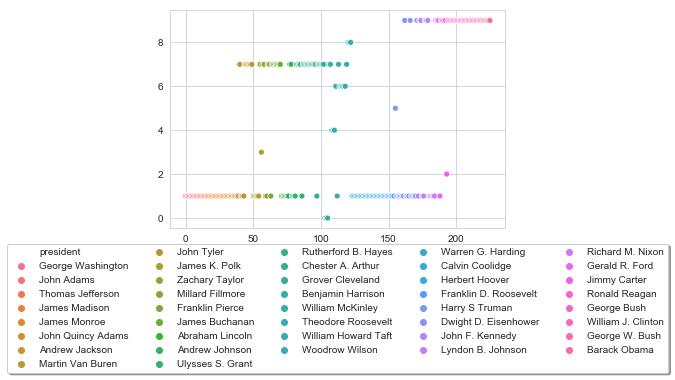

In [342]:
cluster(10, 50)

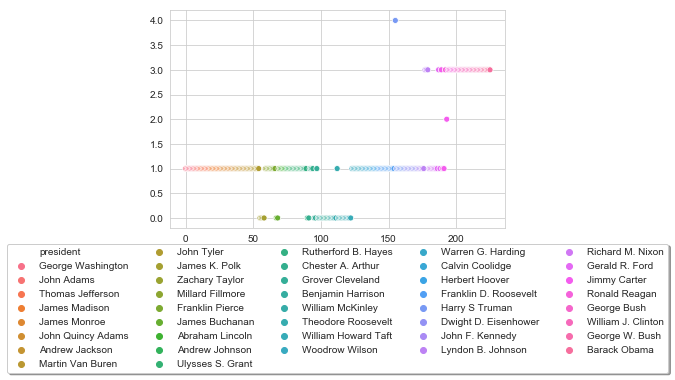

In [32]:
cluster(5, 50)

In [46]:
# by year
def cluster_year(c, it):
    model = KMeans(n_clusters=c, random_state=0,max_iter=it)
    sou_clust = model.fit(tfidf_mat.T)
    year = dta['year'].astype('int')
    y = sou_clust.labels_
    ax = sns.scatterplot(year, y, hue=y)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
             fancybox=True, shadow=True, ncol=5)

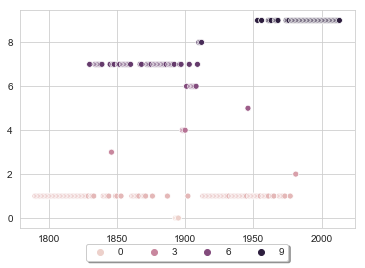

In [53]:
cluster_year(10, 50)

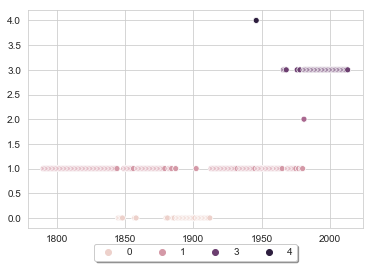

In [49]:
cluster_year(5, 50)

It can be seen that if we classify the sous by year, there are a few years whose patterns are unique and form a class by themselves. However, in gerenal, the majority of sous in early years are classified as one class and more recent sous are classified as one class. 